<a href="https://colab.research.google.com/github/Bhimsendabby/Machine--Learning-practice/blob/main/Image_Colorization_Using_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder Image Colorization

This document provides a step-by-step guide to building an autoencoder using the images dataset. The autoencoder is a type of neural network that learns to compress (encode) the data and then reconstruct (decode) it back to the original form. But in this code we are using autoencoder for image colorization which is a application of autoencoder.

## Table of Contents

1. [Introduction](#introduction)
2. [Setup & Importing Modules](#setup)
3. [Loading Dataset & Data Preprocessing](#data-preprocessing)
4. [Building the Autoencoder](#building-the-autoencoder)
5. [Training the Autoencoder](#training-the-autoencoder)
6. [Evaluating the Autoencoder](#evaluating-the-autoencoder)
7. [Conclusion](#conclusion)

## Introduction

An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning). The goal of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction.

## Setup

First, ensure you have the necessary libraries installed. You can install them using pip if you haven't already.

```bash
pip install torch numpy matplotlib

#Importing Modules

In [14]:
#Importing all the required libraries
import os
from torchvision.io import read_image
import torch
import torch.utils.data
from torch.utils.data import DataLoader,dataset, random_split
import torchvision
from torchvision import transforms,datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time

from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler
import matplotlib.colors as mcolors

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Loading Dataset

In [2]:
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

Dataset URL: https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization
License(s): unknown
 96% 185M/192M [00:04<00:00, 51.0MB/s]
100% 192M/192M [00:04<00:00, 44.8MB/s]


In [3]:
!unzip landscape-image-colorization.zip

Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

# Hyperparameters

In [15]:
RANDOM_SEED = 49
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 100
MANUAL_SEED = 42
SHUFFLE = True

model_path = '/content/drive/MyDrive/models/imagecolorization_autoencoder.pth'
model_path2 = '/content/drive/MyDrive/models/Conv_autoencoder_2.pth'

# Image Pre-processing

In [41]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self,root_directory,transform=None):
    self.directory = root_directory
    self.transform = transform
    self.color_images_labels = os.listdir(os.path.join(root_directory,'color'))
    self.gray_images_labels = os.listdir(os.path.join(root_directory,'gray'))


    self.images = []
    self.colors = []

  def __len__(self):
      return len(self.color_images_labels)

  def __getitem__(self, idx):
      color_img_path = os.path.join(self.directory, 'color', self.color_images_labels[idx])
      gray_img_path = os.path.join(self.directory, 'gray', self.gray_images_labels[idx])
      color_image = read_image(color_img_path)/255.0
      gray_image = read_image(gray_img_path)/255.0
      if self.transform:
        color_transform = self.transform(color_image)
        gray_transform = self.transform(gray_image)
      return color_transform, gray_transform

In [42]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize the image to 150x150 pixels
])

In [43]:
dataset = ImageDataset('/content/landscape Images',transform=transform)

In [44]:
# Split the data into train and test data
train_set, test_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

In [45]:
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [47]:

# Visualize some images
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()

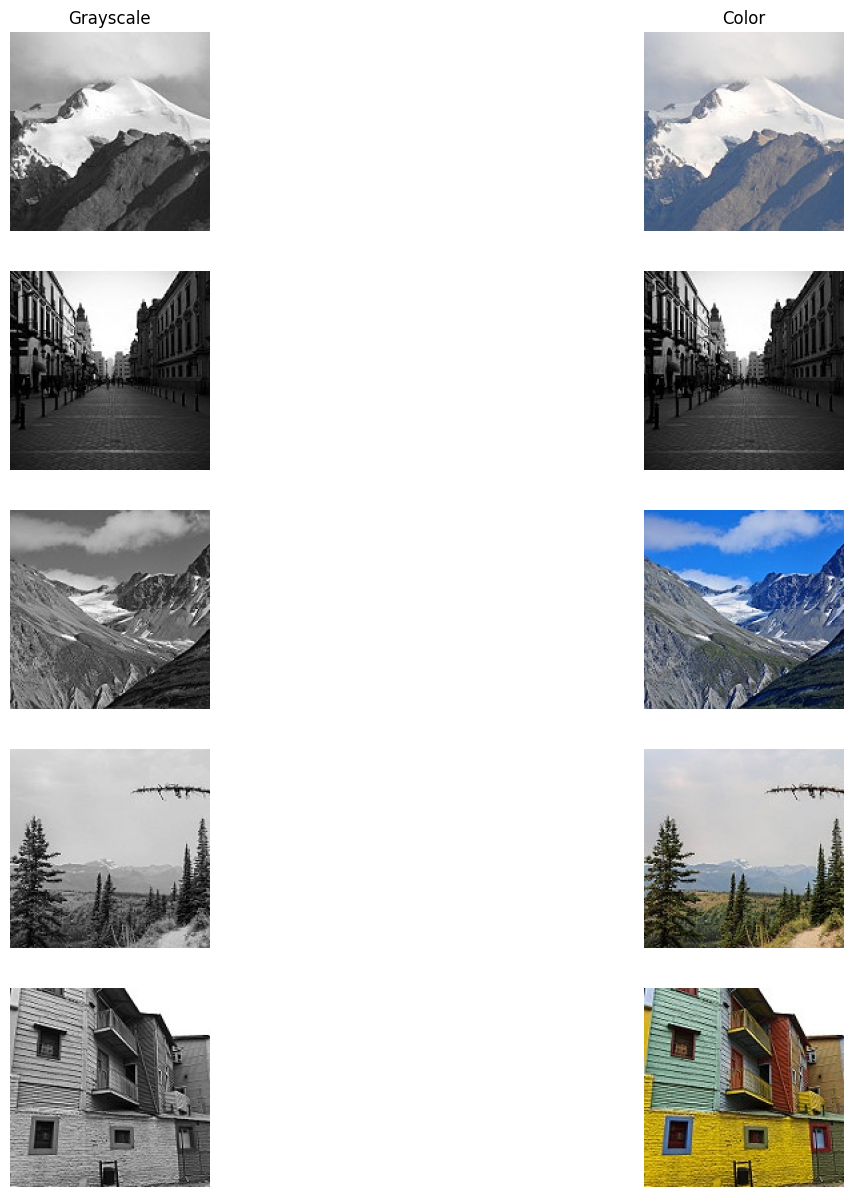

In [48]:
color, gray = next(iter(trainloader))
show_images(color, gray)